# Libraries

In [17]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from models.skip import skip

import torch
import torch.optim
from torchvision import models

from utils.denoising_utils import *

dtype = torch.FloatTensor
mse = torch.nn.MSELoss().type(dtype)

# Load image

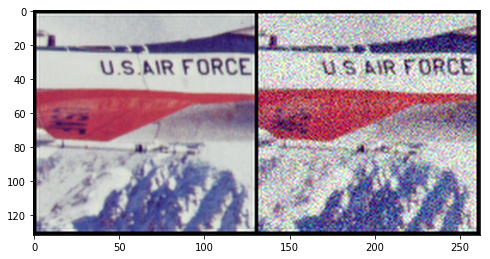

In [18]:
fname = 'data/denoising/F16_GT.png' # image file
sigma = 25 # standard deviation of noise to be added to the image
sigma /= 255. 

img_pil_full, img_np_full = get_image(fname) # pil: uint8 [0, 255], np: numpy array [0, 1]
img_pil = img_pil_full.crop([200,200,328,328])
img_np = pil_to_np(img_pil)

img_torch = np_to_torch(img_np).type(dtype) # torch: PyTorch Tensor

img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma) # noisy image generation
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

plot_image_grid([img_np, img_noisy_np], 4, 6);

# Hyperparameters

Use figure 21 of Paper (Journal) and first table of page 19 for reference: https://box.skoltech.ru/index.php/s/INaUzvTWLak3h7Q

Use PyTorch documentation for v0.4.1: https://pytorch.org/docs/0.4.1/

In [19]:
OPT_OVER = 'net' # optimize 'net', input', or 'net,input' (both)
learning_rate = 0.01 # learning rate of the optimizer
num_iter = 500 # number of iterations

num_input_channels = 32 # number of B&W images in net input
num_output_channels = 3 # if generated image is RGB, 3 channels


num_layers = 5 # number of layers (N)
layer_down_size = [16]*num_layers # vector with number of channels in each layer down (encoder) (nd)
layer_up_size = [16]*num_layers # vector with number of channels in each layer up (decoder) (nu)
skip_size = [4]*num_layers # vector with number of channels in the skip connection at each layer (ns)


filter_size_down = [3]*num_layers # vector with size of filter for convolution in each layer down (kd)
filter_size_up = [3]*num_layers # vector with size of filter for convolution in each layer up (ku)
filter_skip_size = 1 # size of filter for convolution in skip connections (ks)


pad = 'reflection' # padding for convolution is reflection (see nn.ReflectionPad2d)
upsample_mode = 'bilinear' # bilinear upsampling (see nn.Upsample)
downsample_mode = 'stride' # downsampling with convolution (see nn.Conv2d with stride=1)
act_fun = 'LeakyReLU' # non-linear activation function (see nn.LeakyReLU)
need_sigmoid = True # use sigmoid activation function (see nn.Sigmoid)
need_bias = True # adds learnable bias to output of convolutions (see nn.Conv2d)
need1x1_up = True # adds one set of Conv2D+BN+LeakyReLU with filter kernel = 1 to upsampling layers (see figure 21 of Journal)

net_input_noise_std = 1./30.

# create net with these specifications
net = skip(num_input_channels,num_output_channels,layer_down_size,layer_up_size,skip_size,
           filter_size_down,filter_size_up,filter_skip_size,need_sigmoid,need_bias,pad,
           upsample_mode,downsample_mode,act_fun,need1x1_up).type(dtype)

# net input is uniformly distributed ([0, 0.1]) random array of size num_input_channels*H*W
net_input = get_noise(num_input_channels, 'noise', (img_pil.size[1], img_pil.size[0])).type(dtype).detach()



# Optimizer

In [20]:
# get parameters to optimze (these can be the net, the input, or both)
opt_over_list = OPT_OVER.split(',')
params = []
for opt in opt_over_list:
    if opt == 'net':
        params += [x for x in net.parameters()]
    elif opt == 'input':
        net_input.requires_grad = True
        params += [net_input]
    else:
        assert False, 'what is it?'

# set optmizer with these parameters
optimizer = torch.optim.Adam(params, lr=learning_rate)

# Optimization

In [21]:
# vectors to plot MSE at every iteration
MSE1 = []
MSE2 = []

for j in range(num_iter): # for every iteration
    
    optimizer.zero_grad() # clear previous gradient
    out = net(net_input) # calculate output of current net
    loss = mse(out,img_noisy_torch) # calculate the cost function
    #MSE1[j] = loss.detach().numpy() # cost function
    #MSE2[j] = mse(out.detach(),img_torch).numpy() # MSE between generated and original (non-noisy) image
    MSE1.append(loss.detach().numpy())
    MSE2.append(mse(out.detach(),img_torch).numpy())
    if MSE2[j] == np.amin(MSE2[:j+1]):
        best_out = torch_to_np(net(net_input))
        best_idx = j
    loss.backward() # backpropagation (computes gradient of cost function)
    print('Iteration %05d    Loss %f' % (j,loss.item()), '\r', end='')
    optimizer.step() # performs a single optimization step (parameter update)

# Plots

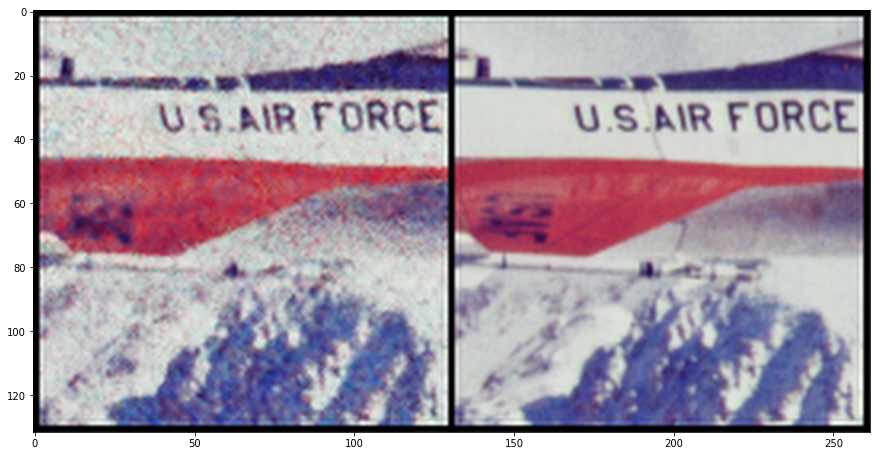

In [16]:
# plot generated image vs. original image
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

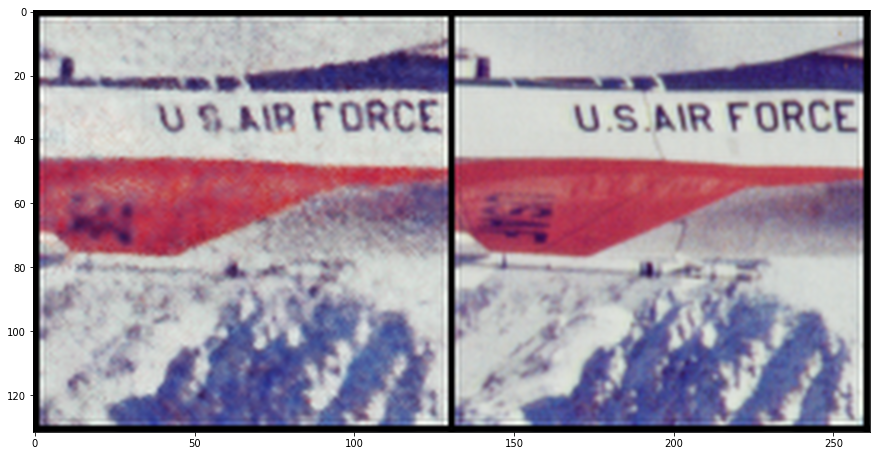

In [17]:
q = plot_image_grid([np.clip(best_out, 0, 1), img_np], factor=13);
print('Iteration %05d\tLoss %f\tMSE %f' % (best_idx,MSE1[best_idx],MSE2[best_idx]), '\r', end='')

In [18]:
# save MSEs at every iteration
fileout1 = 'F16_128_channels16_cost.csv'
fileout2 = 'F16_128_channels16_MSE2.csv'

np.savetxt(fileout1,MSE1,delimiter=',')
np.savetxt(fileout2,MSE2,delimiter=',')

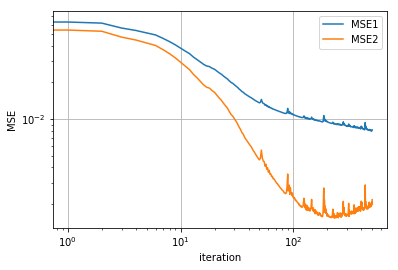

In [19]:
# plot MSEs
p,=plt.plot(MSE1)
q,=plt.plot(MSE2)
plt.xscale('log')
plt.yscale('log') # 'log' or 'linear'
plt.ylabel('MSE')
plt.xlabel('iteration')
plt.legend([p,q],['MSE1', 'MSE2'])
plt.grid(True)
plt.show()

In [20]:
net

Sequential(
  (1): Concat(
    (0): Sequential(
      (1): Sequential(
        (0): ReflectionPad2d((0, 0, 0, 0))
        (1): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
      )
      (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace)
    )
    (1): Sequential(
      (1): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      )
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace)
      (4): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      )
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.2, inplace)
      (7): Sequential(
        (1): Concat(
          (0): Sequential(
            (1): Seque